This is a starter notebook for the project, you'll have to import the libraries you'll need, you can find a list of the ones available in this workspace in the requirements.txt file in this workspace. 

## Step 1: Setting Up the Python Application

In [ ]:
import os
import glob
import pandas as pd
import gradio as gr
import lancedb
import io
import base64
from langchain.chat_models import init_chat_model
from langchain.prompts import ChatPromptTemplate
from sentence_transformers import SentenceTransformer
import torch
from diffusers import StableDiffusion3Pipeline
from IPython.display import Image, display
import re



os.environ["OPENAI_API_KEY"] = "voc-30237581412667733285796716cdfcba5865.61612652"
os.environ["OPENAI_API_BASE"] = "https://openai.vocareum.com/v1"


## Step 2: Generating Real Estate Listings

In [5]:


homes_gen_template = """
Generate CSV formatted descriptions for home listings, with one CSV header row at the top row, and then precisely {home_rows} home rows, to make a total of precisely {total_rows} rows in the CSV.  
The home and neighborhood descriptions should be interesting but also realistic, and display a broad range of homes catering to different house purchaser tastes. Be creative and imaginative.  Commont on items that are a priority for families. 

Each home description should be between 15 and 22 words, and each neighborhood description between 20 and 27 words.

Carefully review the descriptions and any make changes needed to guarantee they are not similar to each other.  

As it is a CSV, ensure all prices and descriptions are between double quotes ("). 

Always include the following Columns in the CSV:
- Neighborhood
- Price
- Bedrooms number
- Bathrooms number
- House Size in square feet
- Detailed Description
- Detailed Neighborhood Description


EXAMPLE with precisely 2 home rows and 3 total rows in the CSV:
Neighborhood,Price,Bedrooms,Bathrooms,House Size (sqft),Description,Neighborhood Description
Sunnyvale,"650,000",4,3,"2,500","Discover your dream home in Sunnyvale! This stunning 4-bedroom, 3-bathroom residence features an expansive open floor plan, perfect for entertaining. The gourmet kitchen is equipped with stainless steel appliances and a large island, while the spacious living room boasts a cozy fireplace. Step outside to a beautifully landscaped backyard, ideal for summer barbecues and family gatherings. The master suite offers a private retreat with a luxurious en-suite bathroom and walk-in closet. Don't miss this opportunity to own a piece of paradise in Sunnyvale!","Sunnyvale is a vibrant community known for its excellent schools and family-friendly atmosphere. With numerous parks, playgrounds, and recreational facilities, there's always something to do. The neighborhood hosts seasonal farmers' markets and community events, fostering a strong sense of belonging. Enjoy easy access to shopping, dining, and major highways, making it a convenient location for commuters."
Maplewood,"1,200,000",5,4,"3,800","Welcome to this exquisite 5-bedroom, 4-bathroom estate in the prestigious Maplewood neighborhood. This luxurious home features high ceilings, elegant crown molding, and hardwood floors throughout. The chef's kitchen is a culinary delight, complete with granite countertops and a spacious pantry. The expansive master suite includes a spa-like bathroom and a private balcony overlooking the lush backyard. Enjoy movie nights in the dedicated home theater or host gatherings in the formal dining room. This home is a true masterpiece!","Maplewood is an upscale neighborhood characterized by tree-lined streets and beautifully manicured lawns. Residents enjoy a peaceful suburban lifestyle while being just minutes away from fine dining, boutique shopping, and cultural attractions. The community is known for its top-rated schools and active neighborhood associations, which organize events and activities throughout the year. With easy access to public transportation and major highways, Maplewood offers the perfect blend of luxury and convenience."
"""

prompt = ChatPromptTemplate.from_template(homes_gen_template)


In [6]:

llm = init_chat_model("gpt-4o", model_provider="openai", temperature=0.0,max_tokens=12000)

In [7]:
chain = prompt | llm

In [8]:
# Generic CSV file versioning helper functions.  These are used to save different versions of the user preferences, and the search results for the user preferences

class VersionedCSVHandler:
    def __init__(self, base_filename, csv_dir="./generated_csvs"):
        """
        Initialize the handler with a base filename.
        
        Args:
            base_filename (str): Base filename without extension (e.g., "user_preferences" or "search_results")
        """
        self.base_filename = base_filename
        self.csv_dir = csv_dir
        if not os.path.exists(csv_dir):
            os.makedirs(csv_dir)
        self.file_pattern = f"{csv_dir}/{base_filename}_*.csv"
    
    def get_version_number(self, next_version=True):
        existing_files = glob.glob(self.file_pattern)
        if existing_files:
            # Extract numbers from filenames and find the maximum
            numbers = [int(f.split('_')[-1].split('.')[0]) for f in existing_files]
            return max(numbers) + 1 if next_version else max(numbers)
        return 1
    
    def save_df_to_csv(self, df):
        next_number = self.get_version_number()
        filename = f"{self.csv_dir}/{self.base_filename}_{next_number}.csv"
        
        df.to_csv(filename, index=False)
        print(f"Data saved to {filename}")
        return filename
      
    def save_content_to_csv(self, csv_content):
        next_number = self.get_version_number()
        filename = f"{self.csv_dir}/{self.base_filename}_{next_number}.csv"
        with open(filename, 'w') as file:
            file.write(csv_content)
        print(f"Data saved to {filename}")
        return filename
    
    def read_from_csv(self, version_number=None):
        try:
            if version_number is None:
                version_number = self.get_version_number(next_version=False)
            filename = f"{self.csv_dir}/{self.base_filename}_{version_number}.csv"
            df = pd.read_csv(filename)
            return df
        except FileNotFoundError:
            print(f"File {filename} not found. No data has been saved yet.")
            return None
        except Exception as e:
            print(f"Error reading data: {str(e)}")
            return None

In [9]:
listings_csv_version_handler = VersionedCSVHandler("home_listings")
pref_csv_version_handler = VersionedCSVHandler("user_preferences")
results_csv_version_handler = VersionedCSVHandler("search_results")

In [70]:

# Define a function to display dataframes with consistent styling
def display_df(df, columns_to_display=None):
    """
    Display search results with proper formatting
    
    Args:
        df (DataFrame): DataFrame containing search results
        columns_to_display (list, optional): List of columns to display. Defaults to key columns.
    """
    # Set pandas display options for full text
    pd.set_option('display.max_colwidth', None)
    
    if columns_to_display is None:
        # Default columns to display
        columns_to_display = df.columns.tolist()

    # Create a styled DataFrame with left alignment
    styled_df = df[columns_to_display].style.set_properties(**{
        'text-align': 'left',
        'white-space': 'normal',
        'width': 'auto'
    })
    
    # Display the styled DataFrame
    display(styled_df)


In [71]:
refresh_listings = False
# refresh_listings = True

df = listings_csv_version_handler.read_from_csv()

# Generate new listings only if file doesn't exist
if refresh_listings or df is None:
    home_rows = 12
    total_rows = home_rows + 1

    print("Generating new home listings...")
    result = chain.invoke(
        {"home_rows": home_rows,
         "total_rows": total_rows}
    )
    print(result)
    content = result.content
    # Simple extraction between markers
    if "```csv" in content and "```" in content:
        start = content.find("```csv") + 6  # Skip past "```csv"
        end = content.rfind("```")
        csv_content = content[start:end].strip()
    else:
        csv_content = content
    listings_csv_version_handler.save_content_to_csv(csv_content)
    print("New home listings generated and saved to CSV")
else:
    print("Using existing home listings previously saved to CSV")

    # Create a styled DataFrame with full text
    display_df(df)

Using existing home listings previously saved to CSV


,Neighborhood,Price,Bedrooms,Bathrooms,House Size (sqft),Description,Neighborhood Description
0,Greenfield,"450,000",3,2,"1,800",Charming 3-bedroom home with a cozy fireplace and modern kitchen. Perfect for first-time buyers or small families.,"Greenfield is a welcoming community with excellent schools, parks, and family-friendly events. Enjoy local cafes and a vibrant arts scene."
1,Riverside,"850,000",4,3,"2,700",Spacious 4-bedroom home with a pool and gourmet kitchen. Ideal for entertaining and family gatherings.,"Riverside offers scenic river views, top-rated schools, and a bustling downtown. Families love the community events and outdoor activities."
2,Oakwood,"1,500,000",5,5,"4,200",Luxurious 5-bedroom estate with a home theater and wine cellar. Perfect for those who love to entertain.,Oakwood is an exclusive neighborhood with tree-lined streets and luxury amenities. Residents enjoy privacy and proximity to fine dining.
3,Lakeside,"600,000",3,2,"2,000",Beautiful lakeside 3-bedroom home with a private dock. Enjoy serene views and water activities.,Lakeside is a tranquil community with excellent schools and outdoor recreation. Families appreciate the peaceful environment and local festivals.
4,Hillcrest,"950,000",4,4,"3,000",Modern 4-bedroom home with a rooftop terrace and smart home features. Ideal for tech-savvy families.,Hillcrest is a vibrant neighborhood with diverse dining options and cultural events. Families enjoy the parks and top-notch schools.
5,Meadowbrook,"700,000",3,3,"2,300",Charming 3-bedroom cottage with a garden and sunroom. Perfect for nature lovers and gardeners.,Meadowbrook is a picturesque community with walking trails and community gardens. Families enjoy the friendly atmosphere and local markets.
6,Seaview,"2,200,000",6,6,"5,000",Stunning 6-bedroom beachfront property with panoramic ocean views. A dream home for beach lovers.,Seaview is a prestigious coastal neighborhood with luxury homes and private beaches. Families enjoy the exclusive lifestyle and ocean activities.
7,Willow Creek,"500,000",3,2,"1,900",Cozy 3-bedroom home with a fireplace and large backyard. Great for families with children.,Willow Creek is a family-friendly neighborhood with excellent schools and parks. Residents enjoy community events and a strong sense of community.
8,Cedar Grove,"1,100,000",4,3,"3,200",Elegant 4-bedroom home with a library and formal dining room. Perfect for those who appreciate classic design.,Cedar Grove is known for its historic charm and cultural attractions. Families enjoy the educational opportunities and community involvement.
9,Sunset Valley,"750,000",3,2,"2,100",Contemporary 3-bedroom home with an open floor plan and large windows. Ideal for modern living.,Sunset Valley is a dynamic neighborhood with trendy shops and cafes. Families appreciate the excellent schools and community spirit.


## Step 3: Storing Listings in a Vector Database

Vector Database Setup: Initialize and configure ChromaDB or a similar vector database to store real estate listings.

Generating and Storing Embeddings: Convert the LLM-generated listings into suitable embeddings that capture the semantic content of each listing, and store these embeddings in the vector database.

In [18]:
# Load the CSV file
df = listings_csv_version_handler.read_from_csv()

# Create combined text for embedding
df = df.fillna('')

# Convert numeric fields to proper numeric types
df['Price'] = df['Price'].str.replace(',', '').astype(int)
df['Bedrooms'] = df['Bedrooms'].astype(int)
df['Bathrooms'] = df['Bathrooms'].astype(float)
df['House Size (sqft)'] = df['House Size (sqft)'].str.replace(',', '').astype(int)

# Load the SentenceTransformer model
emb_model = SentenceTransformer("all-mpnet-base-v2")
if emb_model is None:
    raise ValueError("Failed to load the models. Please check the model names and paths.")


# Initialize LanceDB
os.makedirs("./lancedb_home_data", exist_ok=True)
db = lancedb.connect("./lancedb_home_data")



# A combination of all parameters is not advisable due to truncation of long strings in embedding process
# When searching the db, it is better to combine description matches using vector embeddings with concrete filters on numeric parameters such as price and number of bedrooms
# df['All_text'] = df_filled.agg("; ".join, axis=1)
# df['vector_text'] = df["All_text"] 


# Vector embeddings
df['vector_text'] =  df["Description"] + "  " +df["Neighborhood Description"]


# Suppose df["vector_text"] contains your text to embed
vector_text_list = df["vector_text"].tolist()

embeddings = emb_model.encode(vector_text_list, convert_to_numpy=True)


# Each entry in embeddings is a vector (numpy array)
# Convert them to lists if needed for JSON-friendly storage
df["vector"] = [list(vec) for vec in embeddings]



# Create the table directly from the DataFrame
table = db.create_table(
    "home_listings", 
    data=df,
    mode="overwrite"
)

# Create the vector index
table.create_index(
    vector_column_name="vector",
    metric="Cosine",
    index_type="IVF_FLAT",  
)



print(f"Created table 'home_listings' with {len(df)} records")

# Example query
query = "schools and parks"
query_embedding = emb_model.encode([query], convert_to_numpy=True)[0]


results = (
    table
    .search(query_embedding, query_type="vector")
    .limit(3)
    .to_pandas()
)

print("Search results:")
# Set pandas display options for full text
pd.set_option('display.max_colwidth', None)

# Create a styled DataFrame with left alignment
styled_df = results[["Neighborhood", "vector_text"]].style.set_properties(**{
    'text-align': 'left',
    'white-space': 'normal',
    'width': 'auto'
})

# Display the styled DataFrame
display(styled_df)


Created table 'home_listings' with 12 records
Search results:


,Neighborhood,vector_text
0,Pine Ridge,Spacious 5-bedroom home with a pool and outdoor kitchen. Perfect for hosting summer parties. Pine Ridge is a sought-after neighborhood with top-rated schools and recreational facilities. Families enjoy the active lifestyle and community events.
1,Riverside,"Spacious 4-bedroom home with a pool and gourmet kitchen. Ideal for entertaining and family gatherings. Riverside offers scenic river views, top-rated schools, and a bustling downtown. Families love the community events and outdoor activities."
2,Willow Creek,Cozy 3-bedroom home with a fireplace and large backyard. Great for families with children. Willow Creek is a family-friendly neighborhood with excellent schools and parks. Residents enjoy community events and a strong sense of community.


In [19]:

# Open an existing table named "my_table"
tbl = db.open_table("home_listings")

# Alternatively, to display all data (if the table is small)
tbl.to_pandas()

,Neighborhood,Price,Bedrooms,Bathrooms,House Size (sqft),Description,Neighborhood Description,vector_text,vector
0,Greenfield,450000,3,2.0,1800,Charming 3-bedroom home with a cozy fireplace and modern kitchen. Perfect for first-time buyers or small families.,"Greenfield is a welcoming community with excellent schools, parks, and family-friendly events. Enjoy local cafes and a vibrant arts scene.","Charming 3-bedroom home with a cozy fireplace and modern kitchen. Perfect for first-time buyers or small families. Greenfield is a welcoming community with excellent schools, parks, and family-friendly events. Enjoy local cafes and a vibrant arts scene.","[-0.04811635, -0.03358374, 0.0064837337, 0.037169084, -0.043963242, 0.02014311, -0.0058094915, 0.02623766, -0.03431652, 5.471295e-05, -0.041178018, -0.020973777, 0.016985992, 0.01958308, -0.015111541, 0.07185856, 0.041018475, 0.00365524, -0.056795467, 0.008429039, -0.010319874, 0.009899322, 0.023241844, 0.0086128, -0.029663457, 0.024247639, 0.0013405877, -0.012910159, 0.037226457, 0.048662808, -0.019548161, 0.051272128, -0.059941586, -0.0055373777, 2.21132e-06, 0.024366971, 0.029359683, -0.005148586, 0.04897356, -0.06553944, 0.019249154, 0.013055731, -0.01932325, 0.021452807, -0.018944072, 0.017188692, -0.006086958, 0.089235224, -0.05547025, -0.025053877, 0.00871688, -0.09119402, -0.114246346, 0.015791494, 0.028816855, 0.09841825, -0.014282966, -0.034624092, 0.031932965, -0.060183074, 0.00012147811, -0.022994855, -0.005081006, -0.011581461, 0.067288235, 0.0017707727, 0.005745843, 0.015693614, -0.027670791, 0.041795626, 0.0077946573, -0.016060187, -0.023545075, 0.0026587704, 0.004414961, -0.01772027, 0.018814629, 0.009580105, -0.019943465, -0.0057444945, -0.08663659, -0.03266256, 0.012042596, -0.029602183, 0.09375959, 0.0018028417, -0.0073298626, 0.09417264, -0.055661097, 0.009875161, 0.009891994, 0.055632737, -0.05195264, -0.0037993882, 0.030032901, -0.04131946, -0.03189035, 0.07795294, 0.045034878, 0.058469053, ...]"
1,Riverside,850000,4,3.0,2700,Spacious 4-bedroom home with a pool and gourmet kitchen. Ideal for entertaining and family gatherings.,"Riverside offers scenic river views, top-rated schools, and a bustling downtown. Families love the community events and outdoor activities.","Spacious 4-bedroom home with a pool and gourmet kitchen. Ideal for entertaining and family gatherings. Riverside offers scenic river views, top-rated schools, and a bustling downtown. Families love the community events and outdoor activities.","[-0.07636355, -0.012919575, -0.018228773, 0.06620523, -0.041575596, 0.010153383, -0.03467045, -0.0055453684, -0.046187837, 0.015803503, -0.10441344, 0.031626903, 0.04454278, -0.035592187, -0.036933765, -0.018502368, 0.0058528758, -0.010764468, -0.0055621387, -0.025381217, -0.03443701, 0.003302618, 0.00043911848, -0.029347604, 0.028710075, -0.016503744, -0.027112626, -0.007029145, 0.015766602, 0.00403814, 0.014194989, 0.052452344, -0.0031485811, 0.0060307626, 1.950092e-06, 0.014081288, 0.007321755, 0.0056656837, 0.025867132, -0.03802763, 0.066687204, 0.023749104, -0.0013558558, -0.025322726, 0.0407602, -0.040604573, 0.008398828, 0.047973193, -0.04694527, -0.029082317, 0.009890653, -0.0594727, -0.08413448, -0.005921811, 0.061125953, 0.10140667, -0.010723675, 0.051988404, 0.072593704, 0.021141741, -0.03987164, -0.04296077, -0.0023224067, -0.027289001, 0.038279377, -0.009733913, -0.04905083, 0.0045696925, -0.003475645, 0.0047862036, -0.0008607038, -0.0067291567, -0.0076790024, 0.02980881, -0.030792013, -0.0017363948, 0.018717032, -0.006091616, 0.044697758, -0.016142428, -0.07012847, 0.000113167705, 0.004834806, 0.010791128, 0.09114848, -0.004854473, 0.026175044, 0.05734251, -0.06602217, 0.001998102, 0.037587807, 0.00398996, -0.025445689, 0.01868186, -0.0046180543, -0.0298726, -0.021349879, 0.049649116, 0.039998174, 0.052457985, ...]"
2,Oakwood,1500000,5,5.0,4200,Luxurious 5-bedroom estate with a home theater and wine cellar. Perfect for those who love to enterta

In [20]:
## Let's add a stable diffusion generated image column to the table
refresh_images = False

if refresh_images or not os.path.exists("generated_images"):

    # Create directory to store generated images
    os.makedirs("generated_images", exist_ok=True)

    # Initialize the pipeline
    # You can use different model variants depending on your preference

    pipe = StableDiffusion3Pipeline.from_pretrained("tensorart/stable-diffusion-3.5-medium-turbo", torch_dtype=torch.float16,)

    device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

    print(device)
    pipe = pipe.to(device)


    # Function to generate and save an image
    def generate_property_image(description, neighborhood, index):
        # Create a prompt based on the property description
        prompt = f"Photorealistic photo of a home, with natural outdoor daytime lighting, simulating professional real estate photography, not a drawing. Must be an outside photo of the whole, entire home. Must look like a photo. Description: {description}. Neighborhood: {neighborhood}."

        # Generate the image
        image = pipe(
            prompt=prompt,
            num_inference_steps=30, 
            guidance_scale=8.0, 
            height=256, 
            width=512
            ).images[0]

        # Save image to file
        image_path = f"./generated_images/property_{index}.jpg"
        image.save(image_path)

        # Convert image to base64 for storage in the database
        buffered = io.BytesIO()
        image.save(buffered, format="JPEG")
        img_str = base64.b64encode(buffered.getvalue()).decode()

        return img_str, image_path

    # Open the table
    tbl = db.open_table("home_listings")
    df = tbl.to_pandas()

    # Create columns for image data and path
    df['image_base64'] = None
    df['image_path'] = None

    # Generate images for each property
    for i, row in df.iterrows():
        print(f"Generating image for property {i+1}/{len(df)}: {row['Neighborhood']}")
        description = row['Description']
        neighborhood = row['Neighborhood']
        
        # Generate image
        img_str, img_path = generate_property_image(description, neighborhood, i+1)
        
        # Store data in DataFrame
        df.at[i, 'image_base64'] = img_str
        df.at[i, 'image_path'] = img_path

    # Update the table with the new columns
    db.create_table("home_listings", data=df, mode="overwrite")  # Recreate with new data

    # print("Images generated and added to the database!")

    # Function to display an image from the table
    def display_property_image(index):
        img_path = df.iloc[index]['image_path']
        display(Image(img_path))
        print(f"Property: {df.iloc[index]['Neighborhood']} - {df.iloc[index]['Description']}")

    # Example: Display the first property image
    display_property_image(0)

## Step 4: Building the User Preference Interface



Collect buyer preferences, such as the number of bedrooms, bathrooms, location, and other specific requirements from a set of questions or telling the buyer to enter their preferences in natural language. You can hard-code the buyer preferences in questions and answers, or collect them interactively however you'd like, example:

questions = [   
                "How big do you want your house to be?" 
                "What are 3 most important things for you in choosing this property?", 
                "Which amenities would you like?", 
                "Which transportation options are important to you?",
                "How urban do you want your neighborhood to be?",   
            ]

answers = [
    "A comfortable three-bedroom house with a spacious kitchen and a cozy living room.",
    "A quiet neighborhood, good local schools, and convenient shopping options.",
    "A backyard for gardening, a two-car garage, and a modern, energy-efficient heating system.",
    "Easy access to a reliable bus line, proximity to a major highway, and bike-friendly roads.",
    "A balance between suburban tranquility and access to urban amenities like restaurants and theaters."]
    
Buyer Preference Parsing: Implement logic to interpret and structure these preferences for querying the vector database.

### Interactive user input

In [21]:
# Define the questions
questions = {
    "How big do you want your house to be?  (format: 3-bedroom, 2-bathroom, 2500-sqft, large yard)": "",
    "What are the 3 most important things for you in choosing this property?": "",
    "Are there any specific amenities you would like?": "",
    "What type of neighborhood would you like (urban, suburban, rural, etc.)?": "",
    "Are there any neighborhood preferences (crime rate, school quality, shopping, etc.)?": "",
    "What is your budget? (number in dollars, for example: 500000)": "",
}

# Try to load existing preferences
existing_preferences = pref_csv_version_handler.read_from_csv()
if existing_preferences is not None:
    preferences_dict = dict(zip(existing_preferences['Question'], existing_preferences['Answer']))
    questions.update(preferences_dict)


print(questions)

def save_to_csv(questions_dict, base_filename="user_preferences"):
    df = pd.DataFrame({
        'Question': questions_dict.keys(),
        'Answer': questions_dict.values()
    })
    filename = pref_csv_version_handler.save_df_to_csv(df)

def update_answers(*args):
    answers = dict(zip(questions.keys(), args))
    questions.update(answers)
    save_to_csv(questions)
    
    return {input_container: gr.update(visible=False), output_json: answers}

def cancel_form():
    return {input_container: gr.update(visible=False), output_json: {"status": "Form cancelled"}}

with gr.Blocks() as demo:
    with gr.Column() as input_container:
        # Create textboxes with existing values
        inputs = [gr.Textbox(label=question, value=answer, lines=2) 
                 for question, answer in questions.items()]
        
        with gr.Row():
            submit_btn = gr.Button("Submit", variant="primary")
            cancel_btn = gr.Button("Cancel", variant="stop")
            
    output_json = gr.JSON(label="Your Preferences", visible=False)
    
    submit_btn.click(update_answers, inputs=inputs, outputs=[input_container, output_json])
    cancel_btn.click(cancel_form, inputs=None, outputs=[input_container, output_json])

demo.launch()

{'How big do you want your house to be?  (format: 3-bedroom, 2-bathroom, 2500-sqft, large yard)': '5-bedroom, 4-bathroom, 3500-sqft', 'What are the 3 most important things for you in choosing this property?': 'spacious, beautiful nature and views, luxurious', 'Are there any specific amenities you would like?': 'swimming pool or seaside', 'What type of neighborhood would you like (urban, suburban, rural, etc.)?': 'rural', 'Are there any neighborhood preferences (crime rate, school quality, shopping, etc.)?': 'quiet', 'What is your budget? (number in dollars, for example: 500000)': '2000000'}
* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


## Step 5: Searching Based on Preferences



Semantic Search Implementation: Use the structured buyer preferences to perform a semantic search on the vector database, retrieving listings that most closely match the user's requirements.

Listing Retrieval Logic: Fine-tune the retrieval algorithm to ensure that the most relevant listings are selected based on the semantic closeness to the buyer’s preferences.

In [60]:

# Process user preferences into a meaningful search query
def extract_query_from_preferences(preferences):
    query_parts = {}
    
    # Extract budget
    for question, answer in preferences.items():
        if 'budget' in question.lower() or 'price' in question.lower():
            # Extract numbers from the budget answer
            budget_numbers = re.findall(r'\d[\d,]*', answer)
            if budget_numbers:
                query_parts["Price"] = int(budget_numbers[0].replace(',', ''))
    
    # Extract house size info
    for question, answer in preferences.items():
        if 'big' in question.lower() or 'size' in question.lower():
            # Look for bedroom/bathroom counts and square footage
            bedroom_match = re.search(r'(\d+)[- ]bedroom', answer.lower())
            bathroom_match = re.search(r'(\d+)[- ]bathroom', answer.lower())
            sqft_match = re.search(r'([\d,]+)[- ]sq(?:uare)?[- ]?f(?:ee)?t', answer.lower())
            
            if bedroom_match:
                query_parts["Bedrooms"] = int(bedroom_match.group(1))
            if bathroom_match:
                query_parts["Bathrooms"] = float(bathroom_match.group(1))
            if sqft_match:
                query_parts["House Size (sqft)"] = int(sqft_match.group(1).replace(',', ''))
    
    return (query_parts, " ".join(preferences.values()))

def search_homes_by_preferences(preferences, variation_percentage=0.50, limit=3):
    # Extract query parts from preferences
    query_numeric, query_text = extract_query_from_preferences(preferences)
    query_embedding = emb_model.encode([query_text], convert_to_numpy=True)[0]

    # Build filter conditions for numeric parameters
    filter_conditions = []
    for col, value in query_numeric.items():
        if isinstance(value, int):
            lower_bound = int(value * (1 - variation_percentage))
            upper_bound = int(value * (1 + variation_percentage))
        else:
            lower_bound = value * (1 - variation_percentage)
            upper_bound = value * (1 + variation_percentage)
        filter_conditions.append(f"`{col}` BETWEEN {lower_bound} AND {upper_bound}")
    filter_string = " AND ".join(filter_conditions)

    # Print search parameters
    print("==========================")
    print(f"User Query Numeric: {query_numeric} with allowed variation of {variation_percentage*100}%")
    print("Query bounds:")
    for col, value in query_numeric.items():
        if isinstance(value, int):
            lower_bound = int(value * (1 - variation_percentage))
            upper_bound = int(value * (1 + variation_percentage))
        else:
            lower_bound = value * (1 - variation_percentage)
            upper_bound = value * (1 + variation_percentage)
        print(f"  {col}: {lower_bound} to {upper_bound}")
    print(f"User Query Text: {query_text}")
    print("==========================")

    # Perform the search
    results = (
        table
        .search(query_embedding, query_type="vector")
        .where(filter_string, prefilter=True)
        .limit(limit)
        .to_pandas()
    )

    return results


3-bedroom, 3-bathroom, 2500-sqft * quiet, spacious, beautiful * lake views or a pool * suburban * excellent schools * 700000
User Query Numeric: {'Price': 700000, 'Bedrooms': 3, 'Bathrooms': 3.0, 'House Size (sqft)': 2500} with allowed variation of 50.0%
Query bounds:
  Price: 350000 to 1050000
  Bedrooms: 1 to 4
  Bathrooms: 1.5 to 4.5
  House Size (sqft): 1250 to 3750
User Query Text: 3-bedroom, 3-bathroom, 2500-sqft quiet, spacious, beautiful lake views or a pool suburban excellent schools 700000
Search results:


,Neighborhood,Price,Bedrooms,Bathrooms,House Size (sqft),vector_text
0,Riverside,850000,4,3.000000,2700,"Spacious 4-bedroom home with a pool and gourmet kitchen. Ideal for entertaining and family gatherings. Riverside offers scenic river views, top-rated schools, and a bustling downtown. Families love the community events and outdoor activities."
1,Lakeside,600000,3,2.000000,2000,Beautiful lakeside 3-bedroom home with a private dock. Enjoy serene views and water activities. Lakeside is a tranquil community with excellent schools and outdoor recreation. Families appreciate the peaceful environment and local festivals.
2,Hillcrest,950000,4,4.000000,3000,Modern 4-bedroom home with a rooftop terrace and smart home features. Ideal for tech-savvy families. Hillcrest is a vibrant neighborhood with diverse dining options and cultural events. Families enjoy the parks and top-notch schools.


## Step 6: Personalizing Listing Descriptions

LLM Augmentation: For each retrieved listing, use the LLM to augment the description, tailoring it to resonate with the buyer’s specific preferences. This involves subtly emphasizing aspects of the property that align with what the buyer is looking for.

Maintaining Factual Integrity: Ensure that the augmentation process enhances the appeal of the listing without altering factual information.


In [88]:
prompt_template = """
    You are a real estate agent.
    You are given the buyer's preferences.
    Then, you are given a listing description.

    You are to augment the listing description to resonate with the buyer's preferences. 
    In your augmentation, you should subtly emphasize aspects of the property that align with what the buyer is looking for.
    
    However, you must not alter or generate any factual content that is not given to you in the LISTING DESCRIPTION. 
    Specifically, you must not mention the price, number of bedrooms, number of bathrooms, or square footage unless it is in the LISTING DESCRIPTION.

    BUYER PREFERENCES (NOT FACTUAL INFORMATION):
    {preferences}

    
    
    LISTING DESCRIPTION (FACTUAL INFORMATION):
    {listing_description}
    """

def augment_listing_descriptions(results_df, preferences, llm):
 
    prompt = ChatPromptTemplate.from_template(prompt_template)
    results_df['augmented_description'] = None
    results_df['user_prefs_version'] = pref_csv_version_handler.get_version_number(next_version=False)

    for index, row in results_df.iterrows():
        listing_description = row['vector_text']
        augmented_description = llm.invoke(prompt.format(preferences=preferences, listing_description=listing_description), temperature=0.0)
        results_df.at[index, 'augmented_description'] = augmented_description.content

    return results_df




## Step 7: Deliverables and Testing



Test your "HomeMatch" application and make sure it meets all of the requirements in the rubric(opens in a new tab). Your project code will be run when it's assessed. Enter different "buyer preferences" and ensure it works.

Jupyter Notebook/Python Program: Compile the application code in a Jupyter notebook or a standalone Python program. Ensure the code is well-commented and logically structured.

Example Outputs: Include example outputs showcasing how user preferences are processed and how the application generates personalized listing descriptions. You can include these in comments in your application or in a Jupyter notebook that's saved with outputs.

Showing results for preference set #1:
3-bedroom, 3-bathroom, 2500-sqft * quiet, spacious, beautiful * lake views or a pool * suburban * excellent schools * 700000
User Query Numeric: {'Price': 700000, 'Bedrooms': 3, 'Bathrooms': 3.0, 'House Size (sqft)': 2500} with allowed variation of 50.0%
Query bounds:
  Price: 350000 to 1050000
  Bedrooms: 1 to 4
  Bathrooms: 1.5 to 4.5
  House Size (sqft): 1250 to 3750
User Query Text: 3-bedroom, 3-bathroom, 2500-sqft quiet, spacious, beautiful lake views or a pool suburban excellent schools 700000
Search results:


,Neighborhood,Price,Bedrooms,Bathrooms,House Size (sqft),vector_text
0,Riverside,850000,4,3.000000,2700,"Spacious 4-bedroom home with a pool and gourmet kitchen. Ideal for entertaining and family gatherings. Riverside offers scenic river views, top-rated schools, and a bustling downtown. Families love the community events and outdoor activities."
1,Lakeside,600000,3,2.000000,2000,Beautiful lakeside 3-bedroom home with a private dock. Enjoy serene views and water activities. Lakeside is a tranquil community with excellent schools and outdoor recreation. Families appreciate the peaceful environment and local festivals.
2,Hillcrest,950000,4,4.000000,3000,Modern 4-bedroom home with a rooftop terrace and smart home features. Ideal for tech-savvy families. Hillcrest is a vibrant neighborhood with diverse dining options and cultural events. Families enjoy the parks and top-notch schools.


,Neighborhood,vector_text,augmented_description
0,Riverside,"Spacious 4-bedroom home with a pool and gourmet kitchen. Ideal for entertaining and family gatherings. Riverside offers scenic river views, top-rated schools, and a bustling downtown. Families love the community events and outdoor activities.","This spacious 4-bedroom home is perfect for those seeking a quiet and beautiful suburban lifestyle. With its inviting pool, it's an ideal spot for relaxation and entertaining, offering a sense of tranquility and space. The property is located in Riverside, a community known for its scenic river views and excellent schools, making it a great choice for families. The neighborhood's bustling downtown and community events provide a vibrant yet peaceful atmosphere, ensuring a perfect balance of activity and serenity."
1,Lakeside,Beautiful lakeside 3-bedroom home with a private dock. Enjoy serene views and water activities. Lakeside is a tranquil community with excellent schools and outdoor recreation. Families appreciate the peaceful environment and local festivals.,"Nestled in the heart of a tranquil suburban community, this beautiful lakeside 3-bedroom home offers the perfect blend of quiet and spacious living. With serene lake views right from your doorstep, you can indulge in peaceful mornings and enjoy a variety of water activities from your private dock. The home is situated in Lakeside, a community renowned for its excellent schools, making it an ideal choice for families seeking a nurturing environment. The area is celebrated for its peaceful ambiance and vibrant local festivals, providing a beautiful backdrop for creating lasting memories."
2,Hillcrest,Modern 4-bedroom home with a rooftop terrace and smart home features. Ideal for tech-savvy families. Hillcrest is a vibrant neighborhood with diverse dining options and cultural events. Families enjoy the parks and top-notch schools.,"Nestled in the vibrant Hillcrest neighborhood, this modern 4-bedroom home offers a perfect blend of tranquility and convenience. The spacious design is ideal for those seeking a quiet and beautiful living environment. With its rooftop terrace, you can enjoy serene moments while taking in the picturesque surroundings. The home is equipped with smart home features, catering to tech-savvy individuals who appreciate modern comforts. Hillcrest is renowned for its excellent schools, making it an ideal choice for families prioritizing education. The neighborhood's diverse dining options and cultural events add to the suburban charm, providing a lively yet peaceful atmosphere. Families will also appreciate the nearby parks, perfect for leisurely strolls or outdoor activities."


Property,Image,Description
"Riverside $850,000 4 bed / 3.0 bath 2,700 sqft",,"Personalized Description: This spacious 4-bedroom home is perfect for those seeking a quiet and beautiful suburban lifestyle. With its inviting pool, it's an ideal spot for relaxation and entertaining, offering a sense of tranquility and space. The property is located in Riverside, a community known for its scenic river views and excellent schools, making it a great choice for families. The neighborhood's bustling downtown and community events provide a vibrant yet peaceful atmosphere, ensuring a perfect balance of activity and serenity."
"Lakeside $600,000 3 bed / 2.0 bath 2,000 sqft",,"Personalized Description: Nestled in the heart of a tranquil suburban community, this beautiful lakeside 3-bedroom home offers the perfect blend of quiet and spacious living. With serene lake views right from your doorstep, you can indulge in peaceful mornings and enjoy a variety of water activities from your private dock. The home is situated in Lakeside, a community renowned for its excellent schools, making it an ideal choice for families seeking a nurturing environment. The area is celebrated for its peaceful ambiance and vibrant local festivals, providing a beautiful backdrop for creating lasting memories."
"Hillcrest $950,000 4 bed / 4.0 bath 3,000 sqft",,"Personalized Description: Nestled in the vibrant Hillcrest neighborhood, this modern 4-bedroom home offers a perfect blend of tranquility and convenience. The spacious design is ideal for those seeking a quiet and beautiful living environment. With its rooftop terrace, you can enjoy serene moments while taking in the picturesque surroundings. The home is equipped with smart home features, catering to tech-savvy individuals who appreciate modern comforts. Hillcrest is renowned for its excellent schools, making it an ideal choice for families prioritizing education. The neighborhood's diverse dining options and cultural events add to the suburban charm, providing a lively yet peaceful atmosphere. Families will also appreciate the nearby parks, perfect for leisurely strolls or outdoor activities."

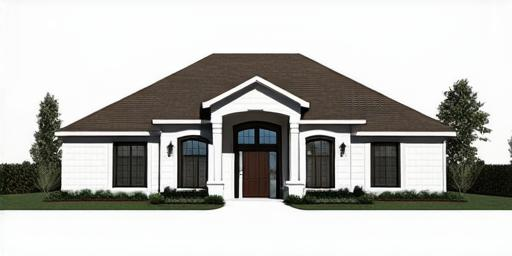
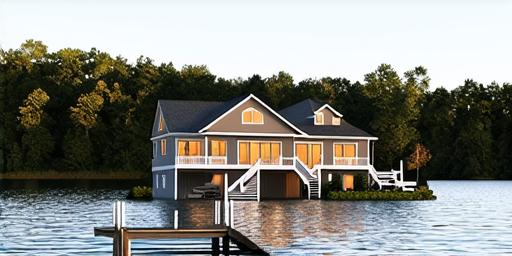
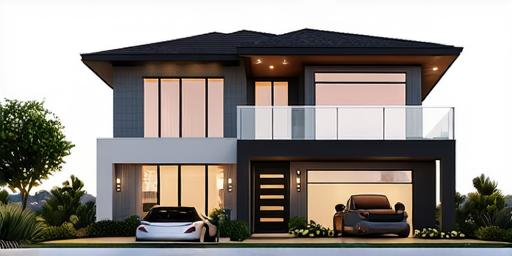

Data saved to ./generated_csvs/search_results_4.csv
HTML saved to ./generated_csvs/homematch_results_1.html for PDF generation in the next step
Showing results for preference set #2:
2-bedroom, 2-bathroom, 1500-sqft * first-time buyers, affordable, close to work * new kitchen * urban * low crime rate, shopping nearby * 400000
User Query Numeric: {'Price': 400000, 'Bedrooms': 2, 'Bathrooms': 2.0, 'House Size (sqft)': 1500} with allowed variation of 50.0%
Query bounds:
  Price: 200000 to 600000
  Bedrooms: 1 to 3
  Bathrooms: 1.0 to 3.0
  House Size (sqft): 750 to 2250
User Query Text: 2-bedroom, 2-bathroom, 1500-sqft first-time buyers, affordable, close to work new kitchen urban low crime rate, shopping nearby 400000
Search results:


,Neighborhood,Price,Bedrooms,Bathrooms,House Size (sqft),vector_text
0,Greenfield,450000,3,2.000000,1800,"Charming 3-bedroom home with a cozy fireplace and modern kitchen. Perfect for first-time buyers or small families. Greenfield is a welcoming community with excellent schools, parks, and family-friendly events. Enjoy local cafes and a vibrant arts scene."
1,Brookside,550000,3,2.000000,2000,Charming 3-bedroom home with a wraparound porch and cozy interior. Ideal for those seeking comfort. Brookside is a friendly neighborhood with parks and local shops. Families enjoy the community events and welcoming atmosphere.
2,Lakeside,600000,3,2.000000,2000,Beautiful lakeside 3-bedroom home with a private dock. Enjoy serene views and water activities. Lakeside is a tranquil community with excellent schools and outdoor recreation. Families appreciate the peaceful environment and local festivals.


,Neighborhood,vector_text,augmented_description
0,Greenfield,"Charming 3-bedroom home with a cozy fireplace and modern kitchen. Perfect for first-time buyers or small families. Greenfield is a welcoming community with excellent schools, parks, and family-friendly events. Enjoy local cafes and a vibrant arts scene.","This charming home is an ideal choice for first-time buyers, offering a modern kitchen that perfectly aligns with your desire for updated amenities. Nestled in the vibrant urban community of Greenfield, you'll appreciate the convenience of nearby shopping and the peace of mind that comes with a low crime rate. The neighborhood's excellent schools and family-friendly events add to the appeal, making it a great place to settle down. Enjoy the cozy fireplace and the vibrant local arts scene, all within a welcoming community that feels like home."
1,Brookside,Charming 3-bedroom home with a wraparound porch and cozy interior. Ideal for those seeking comfort. Brookside is a friendly neighborhood with parks and local shops. Families enjoy the community events and welcoming atmosphere.,"Charming 3-bedroom home with a wraparound porch and cozy interior, perfect for first-time buyers seeking comfort and affordability. Nestled in the urban setting of Brookside, this home offers the convenience of local shops just a short stroll away, making it ideal for those who value easy access to shopping. The friendly neighborhood is known for its low crime rate and vibrant community events, providing a welcoming atmosphere for all residents."
2,Lakeside,Beautiful lakeside 3-bedroom home with a private dock. Enjoy serene views and water activities. Lakeside is a tranquil community with excellent schools and outdoor recreation. Families appreciate the peaceful environment and local festivals.,"Beautiful lakeside home with a private dock, perfect for first-time buyers seeking a serene yet accessible urban lifestyle. While enjoying the tranquil views and water activities, you'll appreciate the convenience of nearby shopping options. Lakeside is a community known for its low crime rate, making it an ideal choice for those prioritizing safety. The area offers excellent schools and a variety of outdoor recreation, ensuring a balanced lifestyle. Families and individuals alike will enjoy the peaceful environment and vibrant local festivals, all within reach of urban amenities."


Property,Image,Description
"Greenfield $450,000 3 bed / 2.0 bath 1,800 sqft",,"Personalized Description: This charming home is an ideal choice for first-time buyers, offering a modern kitchen that perfectly aligns with your desire for updated amenities. Nestled in the vibrant urban community of Greenfield, you'll appreciate the convenience of nearby shopping and the peace of mind that comes with a low crime rate. The neighborhood's excellent schools and family-friendly events add to the appeal, making it a great place to settle down. Enjoy the cozy fireplace and the vibrant local arts scene, all within a welcoming community that feels like home."
"Brookside $550,000 3 bed / 2.0 bath 2,000 sqft",,"Personalized Description: Charming 3-bedroom home with a wraparound porch and cozy interior, perfect for first-time buyers seeking comfort and affordability. Nestled in the urban setting of Brookside, this home offers the convenience of local shops just a short stroll away, making it ideal for those who value easy access to shopping. The friendly neighborhood is known for its low crime rate and vibrant community events, providing a welcoming atmosphere for all residents."
"Lakeside $600,000 3 bed / 2.0 bath 2,000 sqft",,"Personalized Description: Beautiful lakeside home with a private dock, perfect for first-time buyers seeking a serene yet accessible urban lifestyle. While enjoying the tranquil views and water activities, you'll appreciate the convenience of nearby shopping options. Lakeside is a community known for its low crime rate, making it an ideal choice for those prioritizing safety. The area offers excellent schools and a variety of outdoor recreation, ensuring a balanced lifestyle. Families and individuals alike will enjoy the peaceful environment and vibrant local festivals, all within reach of urban amenities."

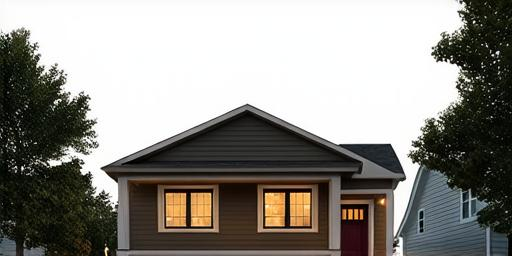
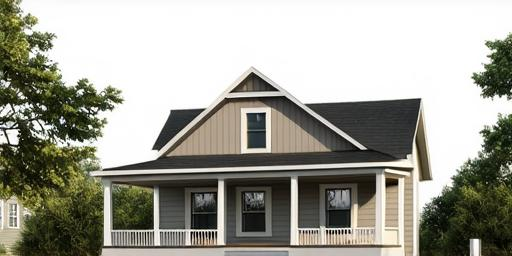
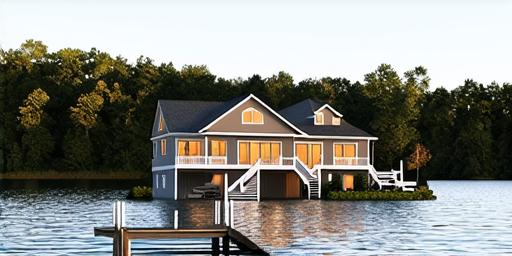

Data saved to ./generated_csvs/search_results_5.csv
HTML saved to ./generated_csvs/homematch_results_2.html for PDF generation in the next step
Showing results for preference set #3:
5-bedroom, 4-bathroom, 3500-sqft * spacious, beautiful nature and views, luxurious * swimming pool or seaside * rural * quiet * 2000000
User Query Numeric: {'Price': 2000000, 'Bedrooms': 5, 'Bathrooms': 4.0, 'House Size (sqft)': 3500} with allowed variation of 50.0%
Query bounds:
  Price: 1000000 to 3000000
  Bedrooms: 2 to 7
  Bathrooms: 2.0 to 6.0
  House Size (sqft): 1750 to 5250
User Query Text: 5-bedroom, 4-bathroom, 3500-sqft spacious, beautiful nature and views, luxurious swimming pool or seaside rural quiet 2000000
Search results:


,Neighborhood,Price,Bedrooms,Bathrooms,House Size (sqft),vector_text
0,Seaview,2200000,6,6.000000,5000,Stunning 6-bedroom beachfront property with panoramic ocean views. A dream home for beach lovers. Seaview is a prestigious coastal neighborhood with luxury homes and private beaches. Families enjoy the exclusive lifestyle and ocean activities.
1,Oakwood,1500000,5,5.000000,4200,Luxurious 5-bedroom estate with a home theater and wine cellar. Perfect for those who love to entertain. Oakwood is an exclusive neighborhood with tree-lined streets and luxury amenities. Residents enjoy privacy and proximity to fine dining.
2,Pine Ridge,1300000,5,4.000000,3600,Spacious 5-bedroom home with a pool and outdoor kitchen. Perfect for hosting summer parties. Pine Ridge is a sought-after neighborhood with top-rated schools and recreational facilities. Families enjoy the active lifestyle and community events.


,Neighborhood,vector_text,augmented_description
0,Seaview,Stunning 6-bedroom beachfront property with panoramic ocean views. A dream home for beach lovers. Seaview is a prestigious coastal neighborhood with luxury homes and private beaches. Families enjoy the exclusive lifestyle and ocean activities.,"Stunning 6-bedroom beachfront property with panoramic ocean views. This dream home offers an expansive and luxurious living experience, perfect for those who value spaciousness and the beauty of nature. Nestled in the prestigious coastal neighborhood of Seaview, this property provides an exclusive lifestyle with private beaches and breathtaking ocean vistas. The serene and quiet surroundings make it an ideal retreat for those seeking a peaceful rural setting. Enjoy the ultimate in luxury living with direct access to ocean activities, making it a haven for beach lovers."
1,Oakwood,Luxurious 5-bedroom estate with a home theater and wine cellar. Perfect for those who love to entertain. Oakwood is an exclusive neighborhood with tree-lined streets and luxury amenities. Residents enjoy privacy and proximity to fine dining.,"Luxurious 5-bedroom estate with a home theater and wine cellar, offering an expansive and spacious living experience. Perfect for those who love to entertain, this property is nestled in the exclusive Oakwood neighborhood, known for its serene, tree-lined streets and luxury amenities. The estate provides a tranquil retreat with beautiful natural surroundings, ideal for those seeking a quiet, rural lifestyle. Residents enjoy privacy and are just a short distance from fine dining, making it a perfect blend of luxury and nature."
2,Pine Ridge,Spacious 5-bedroom home with a pool and outdoor kitchen. Perfect for hosting summer parties. Pine Ridge is a sought-after neighborhood with top-rated schools and recreational facilities. Families enjoy the active lifestyle and community events.,"This spacious 5-bedroom home is a true gem, offering an ideal blend of luxury and tranquility. Nestled in the serene Pine Ridge neighborhood, this property provides a peaceful rural setting, perfect for those seeking a quiet retreat. The home boasts a beautiful outdoor area with a pool, perfect for enjoying the natural surroundings and hosting memorable summer gatherings. The outdoor kitchen adds a touch of luxury, making it an entertainer's dream. Pine Ridge is renowned for its top-rated schools and vibrant community, offering an active lifestyle with plenty of recreational facilities. This property is a perfect match for those who value spacious living, beautiful nature, and a luxurious lifestyle."


Property,Image,Description
"Seaview $2,200,000 6 bed / 6.0 bath 5,000 sqft",,"Personalized Description: Stunning 6-bedroom beachfront property with panoramic ocean views. This dream home offers an expansive and luxurious living experience, perfect for those who value spaciousness and the beauty of nature. Nestled in the prestigious coastal neighborhood of Seaview, this property provides an exclusive lifestyle with private beaches and breathtaking ocean vistas. The serene and quiet surroundings make it an ideal retreat for those seeking a peaceful rural setting. Enjoy the ultimate in luxury living with direct access to ocean activities, making it a haven for beach lovers."
"Oakwood $1,500,000 5 bed / 5.0 bath 4,200 sqft",,"Personalized Description: Luxurious 5-bedroom estate with a home theater and wine cellar, offering an expansive and spacious living experience. Perfect for those who love to entertain, this property is nestled in the exclusive Oakwood neighborhood, known for its serene, tree-lined streets and luxury amenities. The estate provides a tranquil retreat with beautiful natural surroundings, ideal for those seeking a quiet, rural lifestyle. Residents enjoy privacy and are just a short distance from fine dining, making it a perfect blend of luxury and nature."
"Pine Ridge $1,300,000 5 bed / 4.0 bath 3,600 sqft",,"Personalized Description: This spacious 5-bedroom home is a true gem, offering an ideal blend of luxury and tranquility. Nestled in the serene Pine Ridge neighborhood, this property provides a peaceful rural setting, perfect for those seeking a quiet retreat. The home boasts a beautiful outdoor area with a pool, perfect for enjoying the natural surroundings and hosting memorable summer gatherings. The outdoor kitchen adds a touch of luxury, making it an entertainer's dream. Pine Ridge is renowned for its top-rated schools and vibrant community, offering an active lifestyle with plenty of recreational facilities. This property is a perfect match for those who value spacious living, beautiful nature, and a luxurious lifestyle."

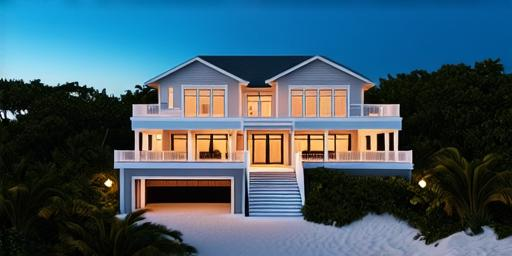
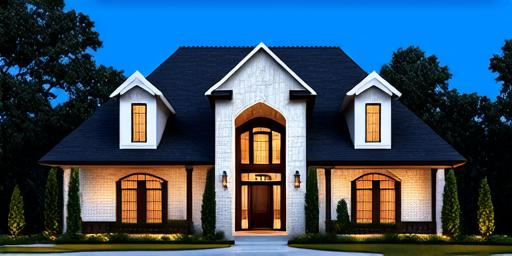
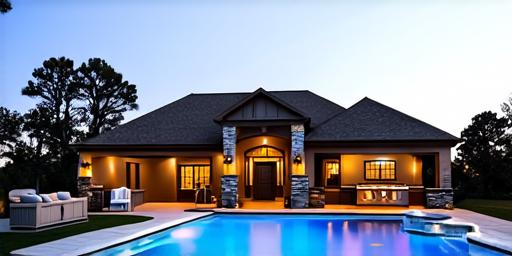

Data saved to ./generated_csvs/search_results_6.csv
HTML saved to ./generated_csvs/homematch_results_3.html for PDF generation in the next step


In [96]:
import base64
import io
from IPython.display import HTML

# Output the results visually and to CSV

preferences_df = pref_csv_version_handler.read_from_csv()
if preferences_df is None:
    print(f"No preferences found. Please fill out the User Preferences form to generate preference CSV files.")

for i in range(pref_csv_version_handler.get_version_number(next_version=False)):
    # Load preferences
    prefs_version = i+1
    preferences_df = pref_csv_version_handler.read_from_csv(version_number=prefs_version)
    
    # Convert preferences DataFrame to dictionary
    preferences = dict(zip(preferences_df['Question'], preferences_df['Answer']))
    
    print(f"Showing results for preference set #{prefs_version}:")
    print(" * ".join(preferences.values()))

    # Perform search with the loaded preferences
    results = search_homes_by_preferences(preferences)
    
    print("Search results:")
    display_df(results[["Neighborhood", "Price", "Bedrooms", "Bathrooms", "House Size (sqft)", "vector_text"]])

    # Call the function to augment listing descriptions
    results = augment_listing_descriptions(results, preferences, llm)
    
    # Display detailed results with augmented descriptions
    display_df(results[['Neighborhood', 'vector_text', 'augmented_description']])

    # Create HTML table with images
    html_output = "<h2>HomeMatch Results</h2>"
    html_output += "<h3>Your Preferences:</h3>"
    html_output += "<p>" + " * ".join(preferences.values()) + "</p>"
    
    # Start HTML table
    html_output += """
    <table style="width:100%; border-collapse: collapse;">
      <tr style="background-color: #f2f2f2;">
        <th style="padding: 12px; text-align: left; border: 1px solid #ddd;">Property</th>
        <th style="padding: 12px; text-align: left; border: 1px solid #ddd;">Image</th>
        <th style="padding: 12px; text-align: left; border: 1px solid #ddd;">Description</th>
      </tr>
    """
    
    # Table rows for each property
    table_df = table.to_pandas()
    for idx, row in results.iterrows():
        # Format price with commas
        formatted_price = f"${row['Price']:,}"
        
        # Find the original index to locate the image
        original_idx = table_df.index[table_df['Neighborhood'] == row['Neighborhood']].tolist()
        image_html = ""
        
        if original_idx:
            image_path = f"./generated_images/property_{original_idx[0]+1}.jpg"
            if os.path.exists(image_path):
                with open(image_path, "rb") as img_file:
                    img_data = base64.b64encode(img_file.read()).decode()
                image_html = f'<img src="data:image/jpeg;base64,{img_data}" style="width:300px;">'
            else:
                image_html = "<p>No image available</p>"
        
        # Add row to table
        html_output += f"""
        <tr style="border: 1px solid #ddd;">
            <td style="padding: 12px; vertical-align: top; border: 1px solid #ddd;">
                <strong>{row['Neighborhood']}</strong><br>
                {formatted_price}<br>
                {row['Bedrooms']} bed / {row['Bathrooms']} bath<br>
                {row['House Size (sqft)']:,} sqft
            </td>
            <td style="padding: 12px; vertical-align: top; border: 1px solid #ddd;">
                {image_html}
            </td>
            <td style="padding: 12px; vertical-align: top; border: 1px solid #ddd;">
                <p><strong>Personalized Description:</strong><br>
                {row['augmented_description']}</p>
            </td>
        </tr>
        """
    
    # Close HTML table
    html_output += "</table>"
    
    # Display HTML
    display(HTML(html_output))

    # Save results to CSV
    results_csv_version_handler.save_df_to_csv(results)
    
    # Save HTML to file for PDF generation in next cell
    html_filename = f"./generated_csvs/homematch_results_{prefs_version}.html"
    with open(html_filename, "w") as f:
        f.write(html_output)
    print(f"HTML saved to {html_filename} for PDF generation in the next step")



## Step 8: Project Submission


Generated Listings: Include a file that contains your synthetically generated real estate listings. Name this file "listings"

Project Documentation: Include a readme file or an accompanying document explaining the functionality, how to run the code, and any prerequisites or dependencies.

Code Submission: Submit the Jupyter Notebook or Python program on the "Project Submission Page" that follows the workspace page.
